In [4]:
from cellpose import models, io
model = models.CellposeModel(gpu=True, model_type=r"C:\Users\B30027\.cellpose\models\model_BDL6_label_test")
img = io.imread(r"D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\PC\PC-100X-2.jpg")
masks, flow, _ = model.eval(img, channels=[0, 0])
io.save_masks(images=img, masks=masks, flows=flow, png=False, save_txt=True, file_names="LysoTracker-100X-2")

# Crop cell image

In [ ]:
import os
import cv2
import numpy as np
import torch
from cellpose import models, io
from torchvision.ops import masks_to_boxes

In [ ]:
# Function to get image paths by type (PC or LysoTracker)
def get_image_paths(folder_path):
    image_paths = [
        os.path.join(folder_path, file_name)
        for file_name in os.listdir(folder_path)
        if file_name.endswith(".jpg")
    ]
    return image_paths

In [ ]:
# Function to extract the shared identifier after the first '-'
def extract_identifier(file_name):
    return file_name.split('-', 1)[1]  # Split at the first '-' and return the second part

In [ ]:
# Function to get masks using the Cellpose model
def get_masks(img_path):
    model = models.CellposeModel(gpu=True, model_type=r"C:\Users\B30027\.cellpose\models\model_BDL6_label_test")
    img = io.imread(img_path)
    masks, flow, _ = model.eval(img, channels=[0, 0])  # Use channel 0 for grayscale (PC images)
    
    return masks

In [ ]:
def outlines_to_text(base, outlines):
    with open(base + "_cp_outlines.txt", "w") as f:
        for o in outlines:
            xy = list(o.flatten())
            xy_str = ",".join(map(str, xy))
            f.write(xy_str)
            f.write("\n")

In [ ]:
def get_outlines(masks):
    """Get outlines of masks as a list to loop over for plotting.

    Args:
        masks (ndarray): masks (0=no cells, 1=first cell, 2=second cell,...)

    Returns:
        list: List of outlines as pixel coordinates.

    """
    outpix = []
    for n in np.unique(masks)[1:]:
        mn = masks == n
        if mn.sum() > 0:
            contours = cv2.findContours(mn.astype(np.uint8), mode=cv2.RETR_EXTERNAL,
                                        method=cv2.CHAIN_APPROX_NONE)
            contours = contours[-2]
            cmax = np.argmax([c.shape[0] for c in contours])
            pix = contours[cmax].astype(int).squeeze()
            if len(pix) > 4:
                outpix.append(pix)
            else:
                outpix.append(np.zeros((0, 2)))
    return outpix

In [ ]:
# Main function to process images and crop based on masks
def process_images_and_crop(pc_folder_path, lyso_folder_path, output_folder):
    # Get PC and LysoTracker images
    pc_images = get_image_paths(pc_folder_path)
    lyso_images = get_image_paths(lyso_folder_path)

    # Process each PC image
    for pc_img_path in pc_images:
        pc_base_name = os.path.basename(pc_img_path)
        pc_identifier = extract_identifier(pc_base_name)  # Get the identifier (e.g., "100X-2.jpg")
        
        # Find the corresponding LysoTracker image
        lyso_img_path = next((img for img in lyso_images if extract_identifier(os.path.basename(img)) == pc_identifier), None)

        if lyso_img_path:
            # Read the PC and LysoTracker images
            lyso_img = cv2.imread(lyso_img_path)
            masks = get_masks(pc_img_path)

            # Get unique labels (ignoring background label 0)
            unique_labels = np.unique(masks)[1:]  # Ignore label 0 which is background
            
            # Create binary masks for each object
            binary_masks = np.array([(masks == label).astype(np.uint8) for label in unique_labels])

            # Transform masks to outlines
            outlines = get_outlines(binary_masks)
            
            # Convert masks to tensor for bounding box calculation
            masks_tensor = torch.tensor(binary_masks, dtype=torch.float32)
            
            # Compute bounding boxes for each mask
            bounding_boxes = masks_to_boxes(masks_tensor)

            # Mask the image and crop using bounding boxes
            masked_img = lyso_img.copy()  # Use LysoTracker image for cropping
            
            base_name = os.path.splitext(os.path.basename(lyso_img_path))[0]

            for i, box in enumerate(bounding_boxes):
                x_min, y_min, x_max, y_max = map(int, box)
                
                # Create a copy of the image and apply the current binary mask
                current_mask = binary_masks[i]
                masked_img_copy = masked_img.copy()
                masked_img_copy[current_mask == 0] = 0  # Set pixels where mask is 0 to black

                # Crop the image using the bounding box
                cropped_img = masked_img_copy[y_min:y_max, x_min:x_max]  

                # Create the output path and save the cropped image
                output_img_path = os.path.join(output_folder, f"{base_name}_{i}.jpg")
                output_txt_path = os.path.join(output_folder, f"{base_name}_{i}_cp_outlines.txt")
                outlines_to_text(output_txt_path, outlines)
                cv2.imwrite(output_img_path, cropped_img)
                print(f"Saved cropped image: {output_img_path}")
        else:
            print(f"No matching LysoTracker image found for {pc_base_name}")

In [14]:
# Example usage:
pc_folder_path = r"D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\PC"
df_folder_path = r"D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF"
output_folder = r"D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output"

process_images_and_crop(pc_folder_path, df_folder_path, output_folder)

d:\anaconda3\envs\pyimagej\lib\site-packages\cellpose\resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=devic

Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_0.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_1.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_2.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_3.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_4.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_5.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_6.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_7.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_8.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\DF_output\DF-100X-10_9.JPG
Saved cropped image: D:\Project\fiji-win64\Fiji.ap

# Initalize PyImagej

In [1]:
import imagej

ij = imagej.init(r"D:\Project\prolifmsc\prolifmsc\Fiji.app", mode="interactive")
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.14.0/1.54f


# Run Macro

In [9]:
macro = """
#@ String imagePth
#@ String inputFile
#@ String outputFile
from ij import IJ
from ij.plugin.frame import RoiManager
from ij.gui import PolygonRoi
from ij.gui import Roi
from java.awt import Window


img = IJ.openImage(imagePth)
img.show()

rm = RoiManager.getInstance()
if rm is None:
    rm = RoiManager()

imp = IJ.getImage()

IJ.run("Clear Results")
rm.runCommand("Delete")

with open(inputFile, "r") as textfile:
    for line in textfile:
        xy = list(map(int, line.rstrip().split(",")))  
        X = xy[::2]
        Y = xy[1::2]
        if len(X) > 2 and len(Y) > 2:  
            imp.setRoi(PolygonRoi(X, Y, Roi.POLYGON))
            roi = imp.getRoi()
            if roi is not None:  
                rm.addRoi(roi)

rm.runCommand("Show None")
IJ.run("Set Measurements...", "area mean perimeter fit shape feret's redirect=None decimal=3")
rm.select(0)
rm.runCommand("Measure")
rm.runCommand("Deselect")
rm.select(1)
rm.runCommand("Measure")
rm.runCommand("Deselect")
IJ.saveAs("Results", outputFile)

IJ.run("Clear Results")
rm.runCommand("Delete")

with open(inputFile, "r") as textfile:
    for line in textfile:
        xy = list(map(int, line.rstrip().split(",")))
        X = xy[::2]
        Y = xy[1::2]
        if len(X) > 2 and len(Y) > 2:
            imp.setRoi(PolygonRoi(X, Y, Roi.POLYGON))
            IJ.run(imp, "Convex Hull", "")
            roi = imp.getRoi()
            if roi is not None:
                rm.addRoi(roi)

rm.runCommand("Show None")
IJ.run("Set Measurements...", "perimeter redirect=None decimal=3")
rm.select(0)
rm.runCommand("Measure")
rm.runCommand("Deselect")
rm.select(1)
rm.runCommand("Measure")
rm.runCommand("Deselect")
IJ.saveAs("Results", outputFile1)

IJ.run("Clear Results")
rm.runCommand("Delete")

with open(inputFile, "r") as textfile:
    for line in textfile:
        xy = list(map(int, line.rstrip().split(",")))
        X = xy[::2]
        Y = xy[1::2]
        if len(X) > 2 and len(Y) > 2:
            imp.setRoi(PolygonRoi(X, Y, Roi.POLYGON))
            roi = imp.getRoi()
            if roi is not None:
                rm.addRoi(roi)

rm.runCommand("Show None")
IJ.run("Set Measurements...", "integrated redirect=None decimal=3")

if rm.getCount() > 1:
    rm.select(0)
    rm.runCommand("Rename", "nuclei_0")
    rm.runCommand("Deselect")

    rm.select(1)
    rm.runCommand("Rename", "cyto")
    
    cyto_index = rm.getIndex("cyto")
    rm.select(cyto_index)
    roi = rm.getRoi(cyto_index)
    cyto_bounds = roi.getBounds()
    cyto_w = cyto_bounds.width
    cyto_h = cyto_bounds.height
    rm.runCommand("Deselect")

    if cyto_w > cyto_h:
        cyto_threshold = cyto_w
    elif cyto_w < cyto_h:
        cyto_threshold = cyto_h
    else:
        cyto_threshold = cyto_w  

    for i in range(10):
        nuclei_index = rm.getIndex("nuclei_0")
        rm.select(nuclei_index)
        roi = rm.getRoi(nuclei_index)
        roi_bounds = roi.getBounds()

        if (
            roi_bounds.width * (1.5 + (0.5 * i)) <= cyto_threshold
            and roi_bounds.height * (1.5 + (0.5 * i)) <= cyto_threshold
        ):
            rm.scale(1.5 + (0.5 * i), 1.5 + (0.5 * i), True)
            roi = imp.getRoi()
            if roi is not None:
                rm.addRoi(roi)
                rm.runCommand("Rename", "nuclei_{}".format(i + 1))
            rm.runCommand("Deselect")
        else:
            print("out of bound!")
            break

    num_Roi = rm.getCount()
    for i in range(num_Roi - 2):
        n1_index = rm.getIndex("nuclei_{}".format(i))
        n2_index = rm.getIndex("nuclei_{}".format(i + 1))
        rm.setSelectedIndexes([n1_index, n2_index])
        rm.runCommand(imp, "XOR")
        roi = imp.getRoi()
        if roi is not None:
            rm.addRoi(roi)

            num_Roi = rm.getCount()
            rm.select(num_Roi - 1)
            rm.runCommand("Rename", "nuclei_{}{}".format(i, i + 1))
            rm.runCommand("Deselect")

            nxor_index = rm.getIndex("nuclei_{}{}".format(i, i + 1))
            cyto_index = rm.getIndex("cyto")
            rm.setSelectedIndexes([nxor_index, cyto_index])
            rm.runCommand(imp, "AND")
            roi = imp.getRoi()
            if roi is not None:
                rm.addRoi(roi)

                num_Roi = rm.getCount()
                rm.select(num_Roi - 1)
                rm.runCommand("Rename", "nuclei_{}{}F".format(i, i + 1))
                nf_index = rm.getIndex("nuclei_{}{}F".format(i, i + 1))

                rm.select(nf_index)
                rm.runCommand("Measure")

IJ.saveAs("Results", outputFile2)

IJ.run("Clear Results")
rm.runCommand("Delete")

for window in Window.getWindows():
    if window != img.getWindow():
        window.dispose()
"""

In [10]:
args = {
    "imagePth": r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4.JPG",
    "inputFile": r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_cp_outlines.txt",
    "outputFile": r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results.csv",
    "outputFile1": r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results1.csv",
    "outputFile2": r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results2.csv",
}

result = ij.py.run_script("py", macro, args)

In [12]:
import pandas as pd
import os

def merge_results(outputFile, outputFile1, outputFile2, mergedOutputFile):
    """Merge three CSV result files into one and delete the original files.

    Args:
        outputFile (str): Path to the first results CSV.
        outputFile1 (str): Path to the second results CSV.
        outputFile2 (str): Path to the third results CSV.
        mergedOutputFile (str): Path to save the merged results CSV.

    Returns:
        None
    """
    # Read all result files
    df1 = pd.read_csv(outputFile)
    df2 = pd.read_csv(outputFile1)
    df3 = pd.read_csv(outputFile2)

    # Concatenate dataframes
    merged_df = pd.concat([df1, df2, df3], ignore_index=True)

    # Save to a new file
    merged_df.to_csv(mergedOutputFile, index=False)
    print(f"Merged results saved to {mergedOutputFile}")

    # Delete original files
    for file_path in [outputFile, outputFile1, outputFile2]:
        try:
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        except OSError as e:
            print(f"Error deleting file {file_path}: {e}")

outputFile = r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results.csv"
outputFile1 = r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results1.csv"
outputFile2 = r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results2.csv"
mergedOutputFile = r"D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_finalresults.csv"
merge_results(outputFile, outputFile1, outputFile2, mergedOutputFile)

Merged results saved to D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_finalresults.csv
Deleted file: D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results.csv
Deleted file: D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results1.csv
Deleted file: D:\Project\prolifmsc\prolifmsc\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-2_4_results2.csv


# Plot intensity

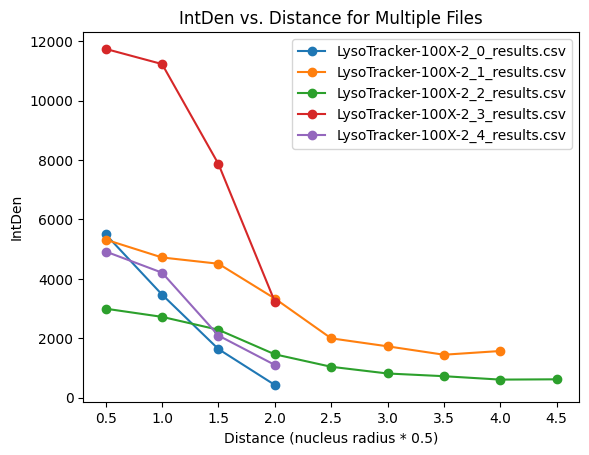

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# 指定 CSV 檔案的路徑，使用 glob 模式來匹配所有的文件
file_pattern = r"D:\Project\fiji-win64\Fiji.app\images\DF_LT_PC\LT_output\LysoTracker-100X-*_results.csv"
csv_files = glob.glob(file_pattern)

distance_increment = 0.5  # 每次增量是 0.5 倍半徑

# 建立圖表
plt.figure()

# 依次讀取每個檔案，並繪製對應的折線
for file_path in csv_files:
    data = pd.read_csv(file_path)
    
    # 獲取 IntDen 列
    y_values = data['IntDen']
    
    # 計算 x 軸的距離 (根據半徑的 0.5 倍增加)
    x_values = [distance_increment * (i+1) for i in range(len(y_values))]
    
    # 在同一圖表上繪製每一組數據
    plt.plot(x_values, y_values, marker='o', label=file_path.split("\\")[-1])  # 使用檔案名作為標籤

# 添加標題與標籤
plt.title('IntDen vs. Distance for Multiple Files')
plt.xlabel('Distance (nucleus radius * 0.5)')
plt.ylabel('IntDen')

# 顯示圖例
plt.legend(loc='best')

# 顯示圖表
plt.show()
